# Field expansion

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Nicer plotting
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np

In [2]:
from pmd_beamphysics import FieldMesh

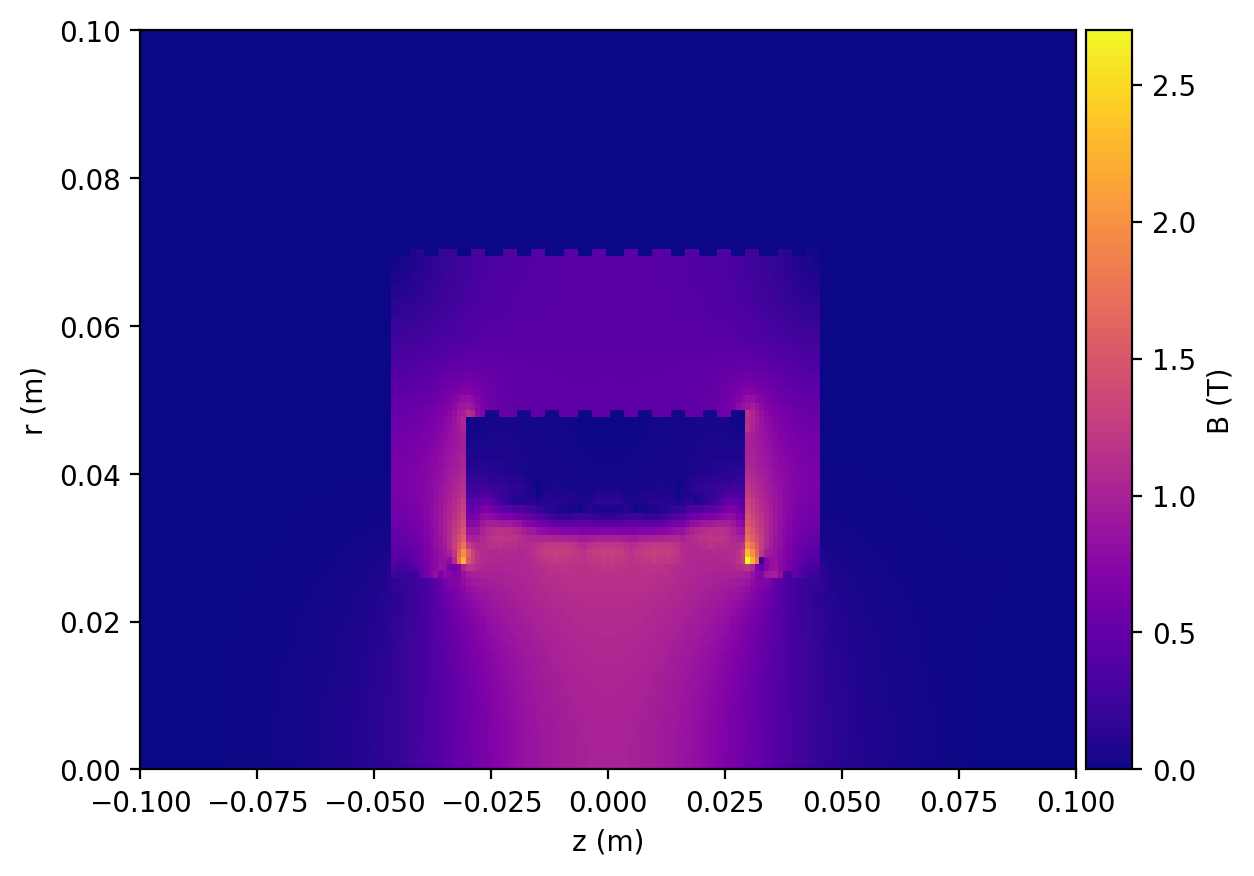

In [3]:
FM = FieldMesh('../data/solenoid.h5')
FM.plot()

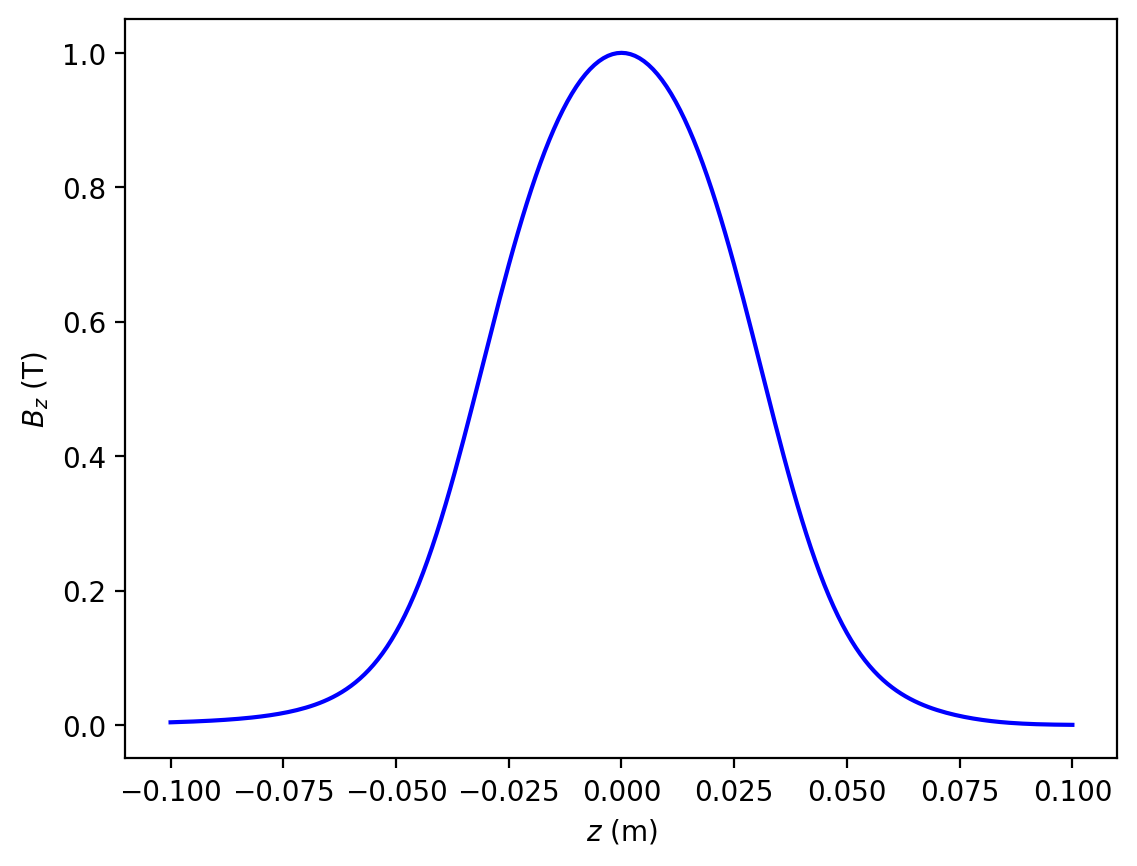

In [4]:
FM.plot_onaxis()

# Derivative array

Field expansions depend on numerical derivatives of the on-axis field. Here are two methods.

In [5]:
from pmd_beamphysics.fields.expansion import fft_derivative_array, spline_derivative_array

In [6]:
Z = FM.coord_vec('z')
DZ = FM.dz
FZ = FM.Bz[0,0,:]

dfield1 = fft_derivative_array(FZ, DZ, ncoef=10)
dfield2 = spline_derivative_array(Z, FZ, s=1e-9)

Text(0, 0.5, '$dB_z/dz$ (T/m)')

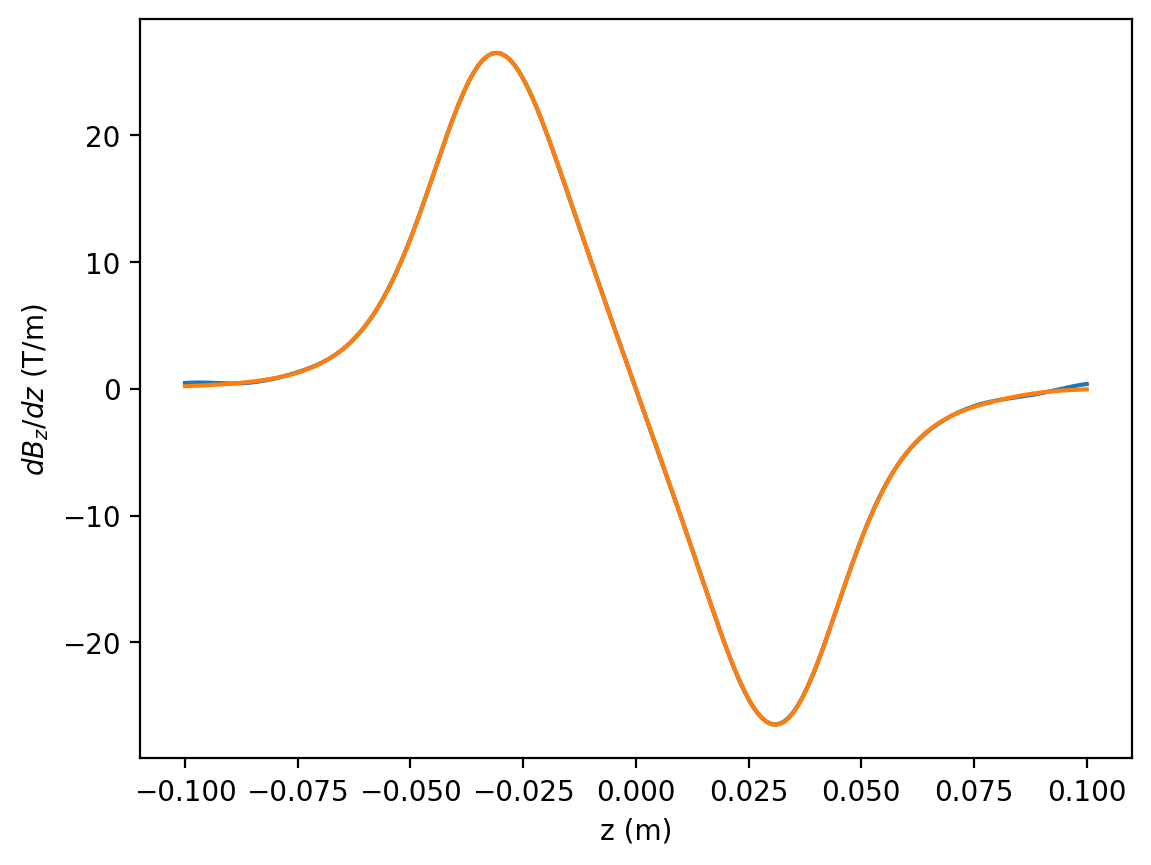

In [7]:
plt.plot(Z, dfield1[:,1], label='fft')
plt.plot(Z, dfield2[:,1], label='spline')
plt.xlabel('z (m)')
plt.ylabel(r'$dB_z/dz$' + r" (T/m)")

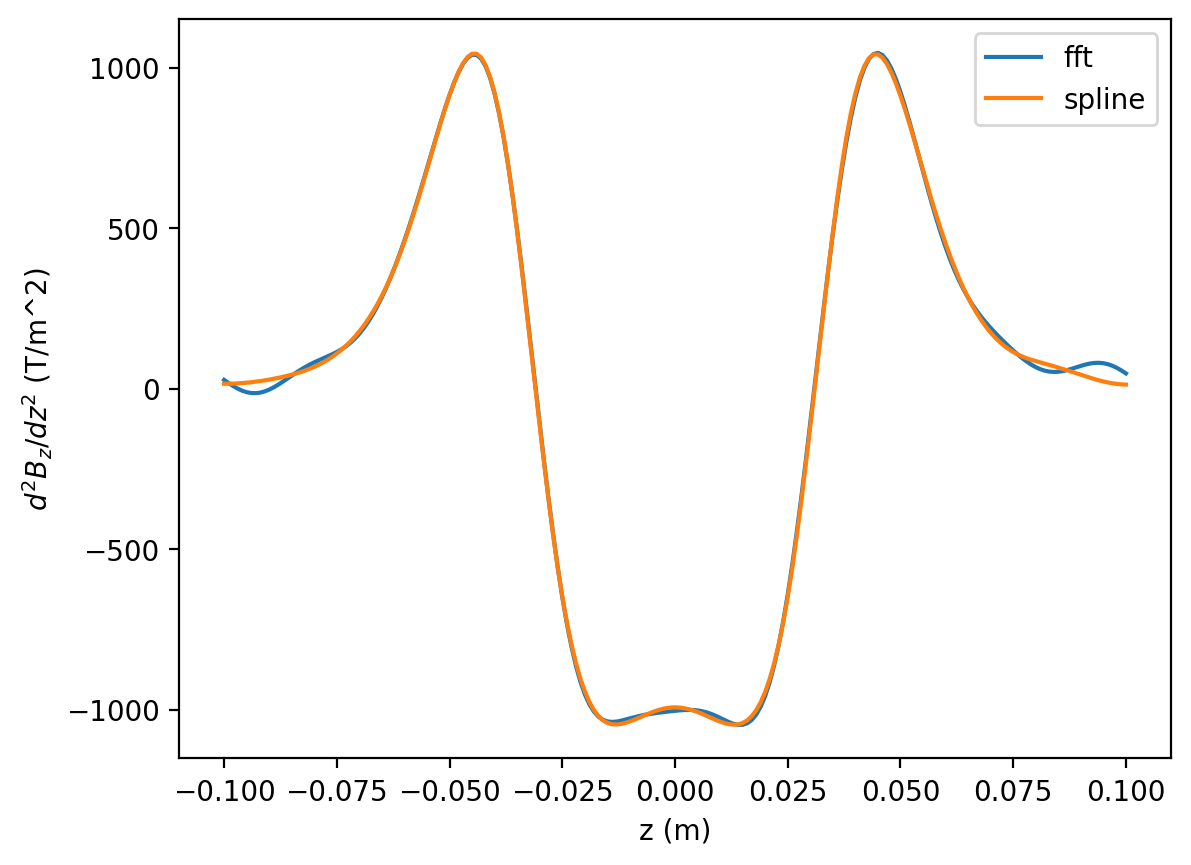

In [8]:
plt.plot(Z, dfield1[:,2], label='fft')
plt.plot(Z, dfield2[:,2], label='spline')
plt.xlabel('z (m)')
plt.ylabel(r'$d^2B_z/dz^2$' + r" (T/m^2)")
plt.legend()

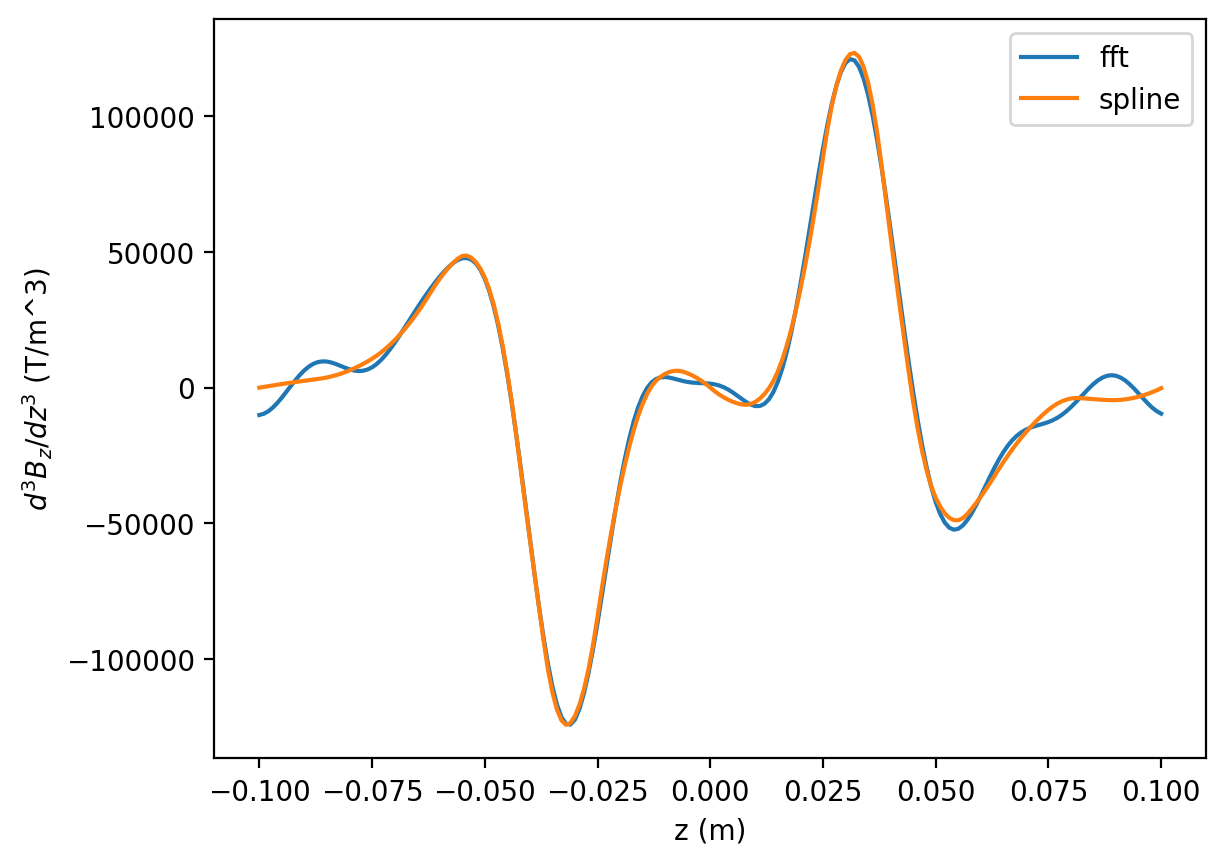

In [9]:
plt.plot(Z, dfield1[:,3], label='fft')
plt.plot(Z, dfield2[:,3], label='spline')
plt.xlabel('z (m)')
plt.ylabel(r'$d^3B_z/dz^3$' + r" (T/m^3)")
plt.legend()

# FieldMesh from 1D data

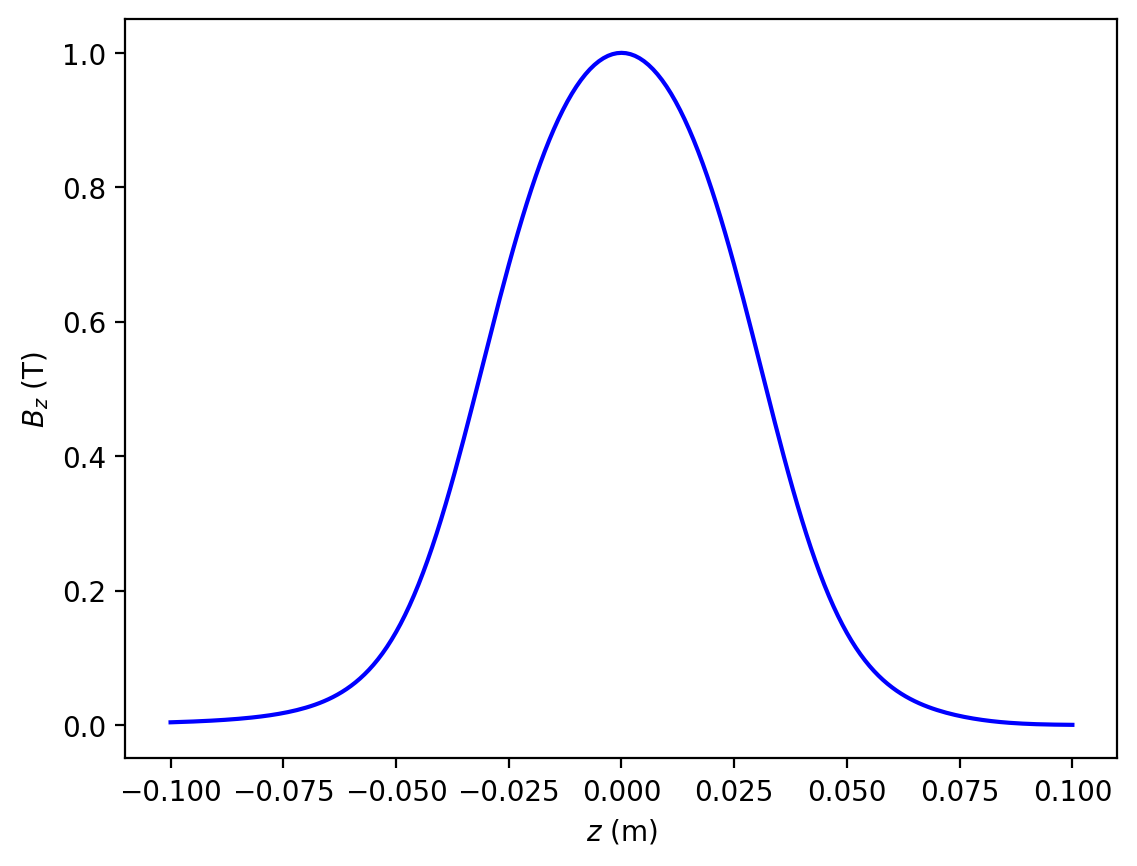

In [10]:
FM2 = FieldMesh.from_onaxis(z=Z, Bz=FZ)
FM2.plot_onaxis()

# Expansion 1D -> 2D

In [11]:
FM3 = FM2.expand_onaxis(dr=FM.dr, nr=10)
FM3

<FieldMesh with cylindrical geometry and (10, 1, 201) shape at 0x146591580>

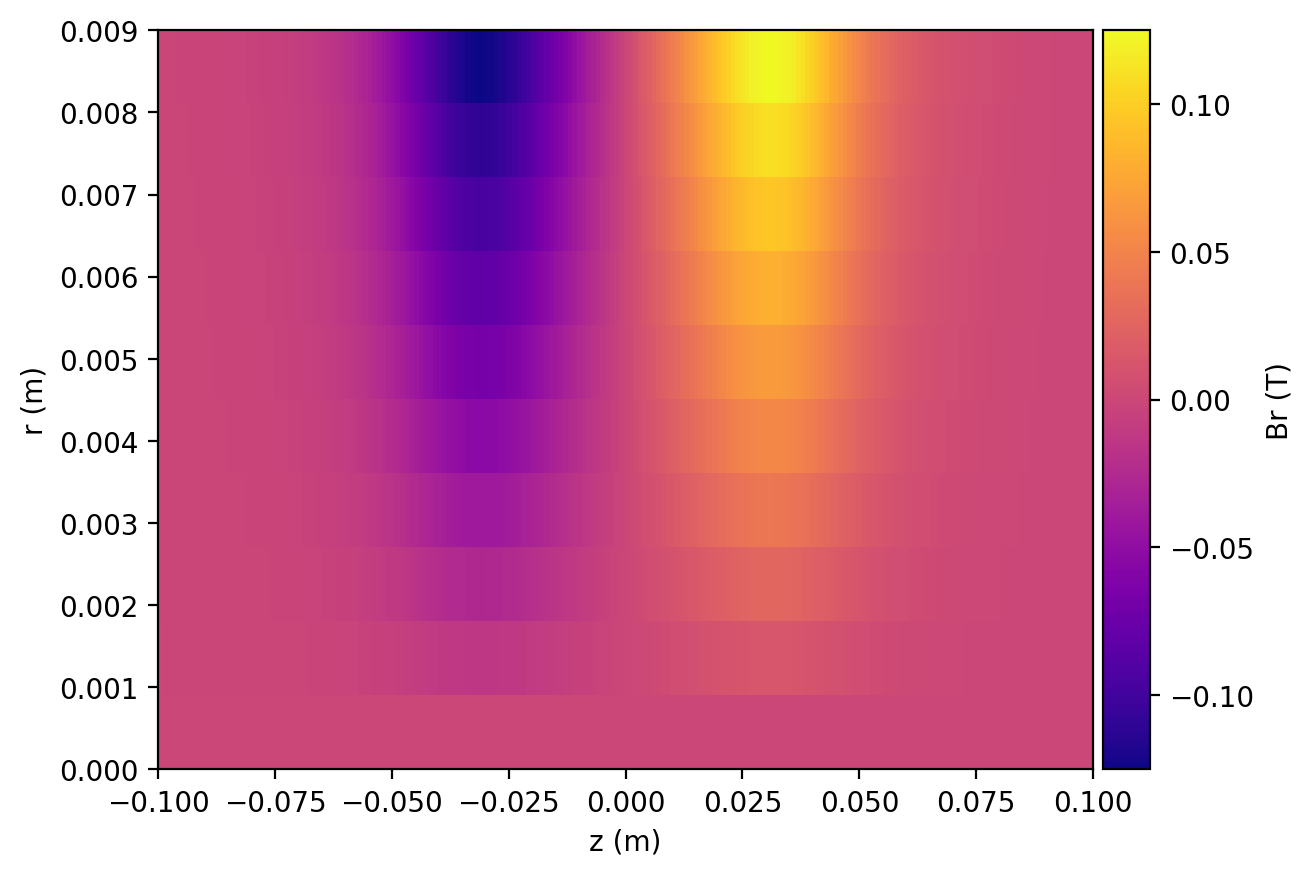

In [12]:
FM3.plot('Br')

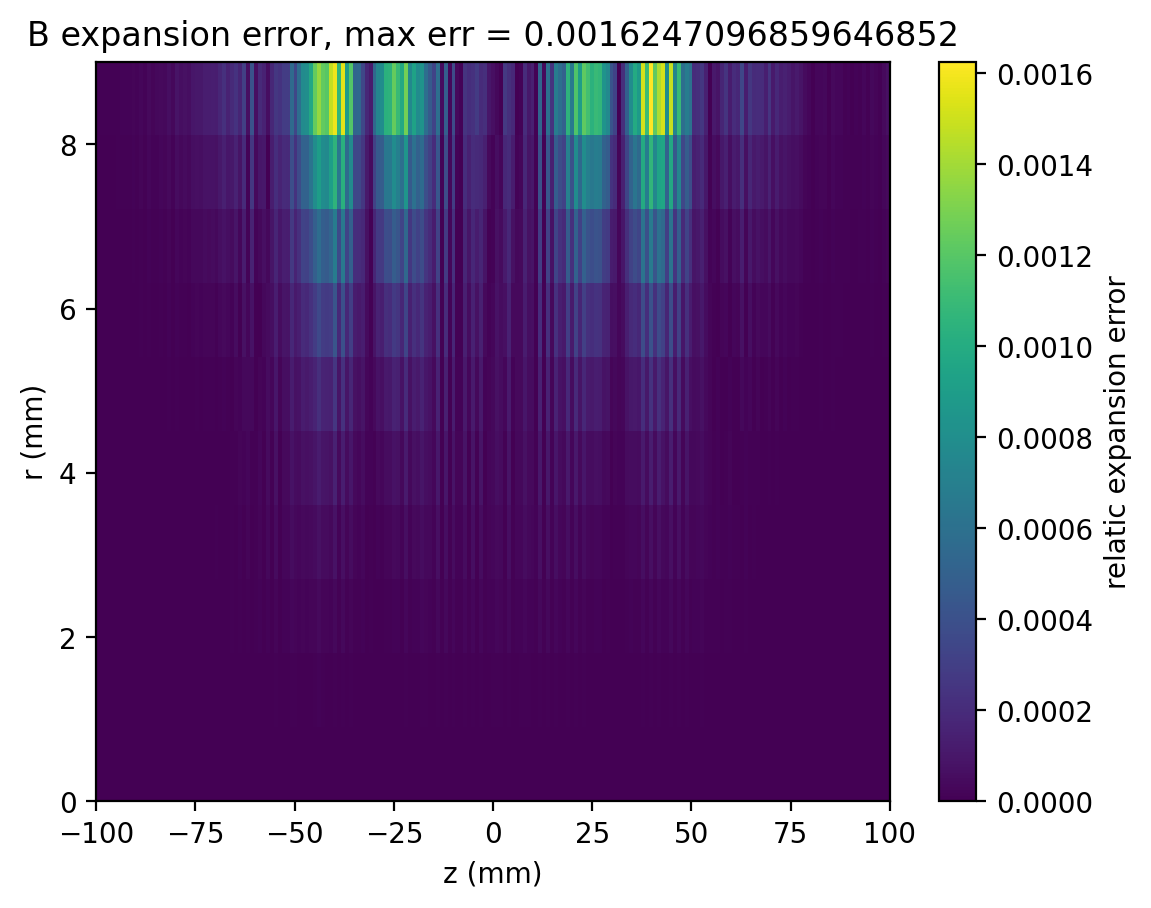

In [13]:
def compare(fm1, fm2, component='Ez'):
    
    z = fm1.coord_vec('z')
    dr = fm1.dr
    nr = min(fm1.shape[0], fm2.shape[0])
    
    unit = fm1.units(component)
    Fz1 =  np.squeeze(fm1[component])[0:nr, :]
    Fz2 =  np.squeeze(fm2[component])[0:nr, :]
    err = abs(Fz1-Fz2) / np.abs(Fz1).max() 
    
    extent = np.array([z.min(), z.max(), 0, dr*(nr-1)]) * 1000
    plt.imshow(err, origin='lower', extent = extent , aspect='auto')
    plt.xlabel('z (mm)')
    plt.ylabel('r (mm)')
    
    plt.title(f"{component} expansion error, max err = {err.max()}")
    plt.colorbar(label=f'relatic expansion error')
    
compare(FM, FM3, 'B')    

# RF Gun 1D -> 2D

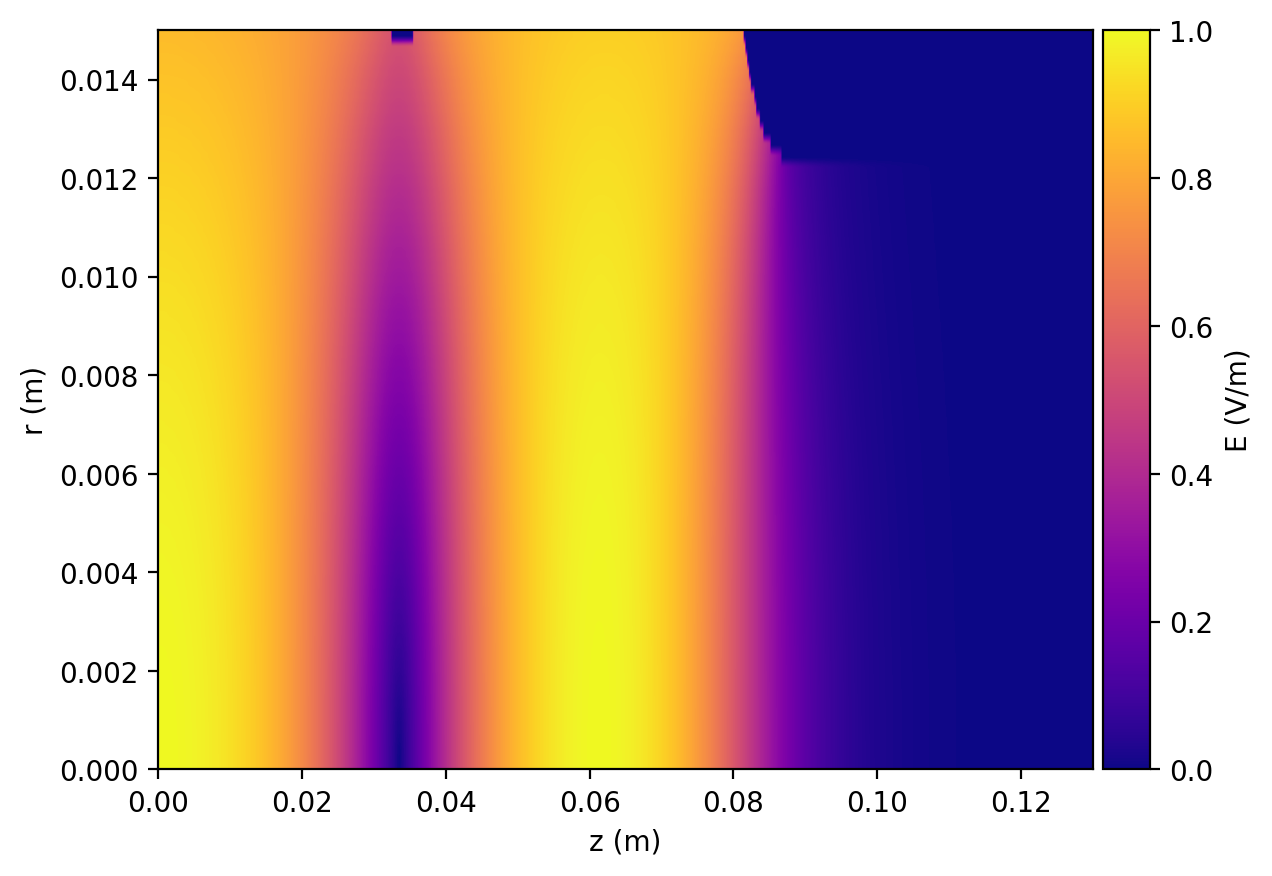

In [14]:
FM = FieldMesh('../data/rfgun.h5')
FM.plot()

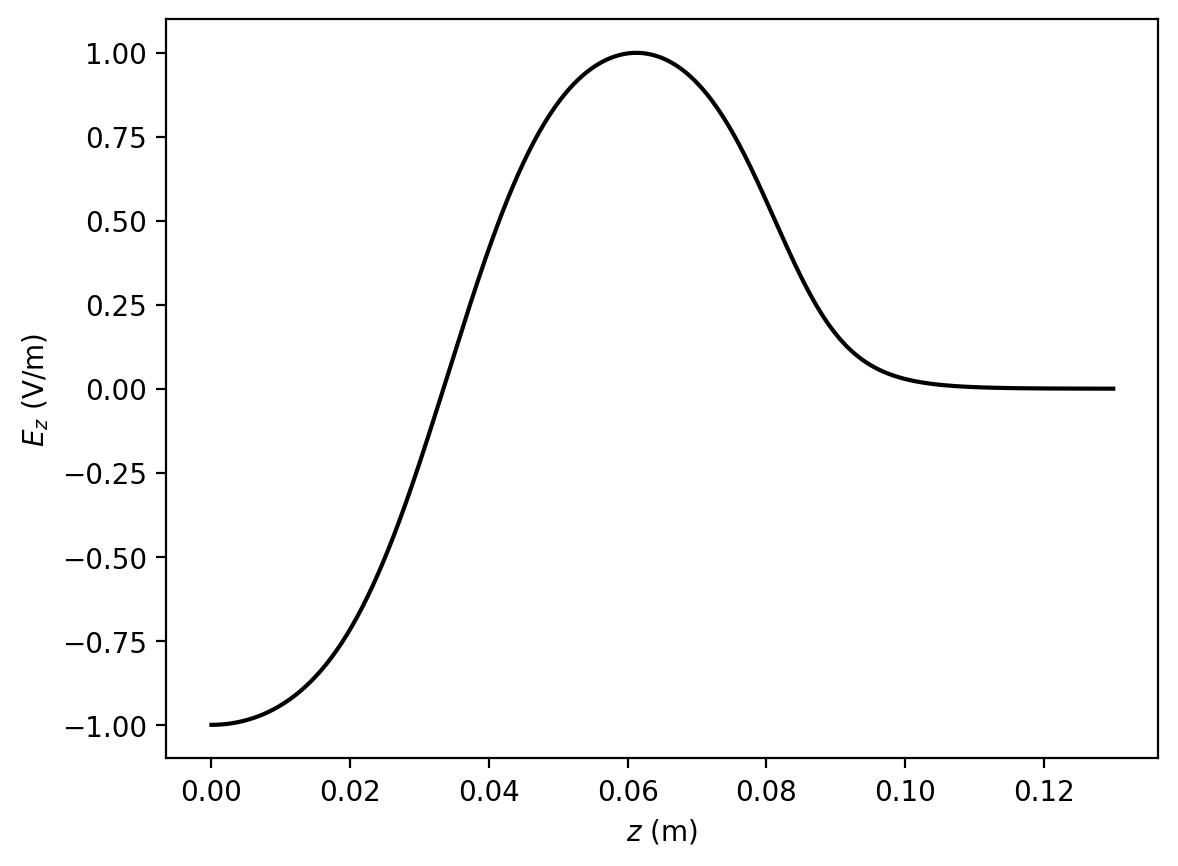

In [15]:
Z = FM.coord_vec('z')
DZ = FM.dz
FZ = np.real(FM.Ez[0,0,:])

FM2 = FieldMesh.from_onaxis(z=Z, Ez=FZ, frequency=FM.frequency)
FM2.plot_onaxis()

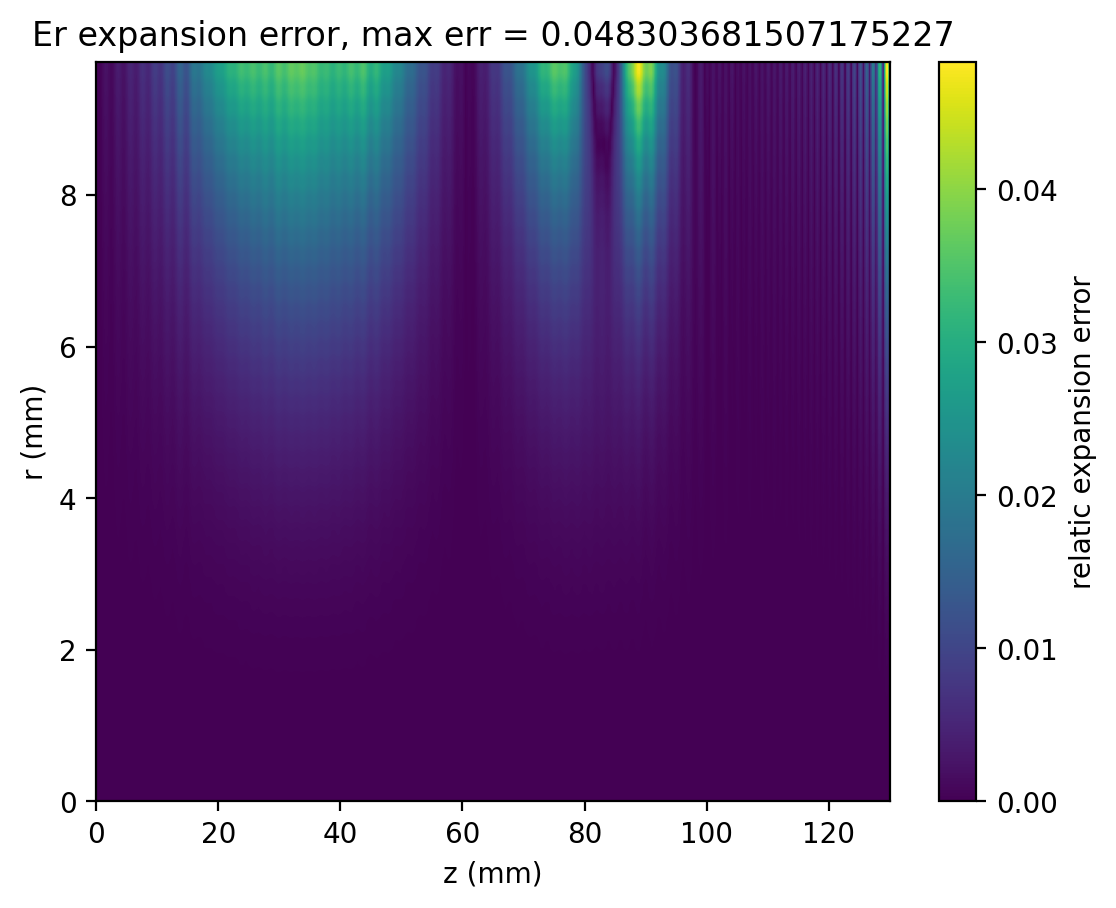

In [16]:
NR = 40
FM3 = FM2.expand_onaxis(dr=FM.dr, nr=NR, method='fft')
compare(FM, FM3, 'Er')   

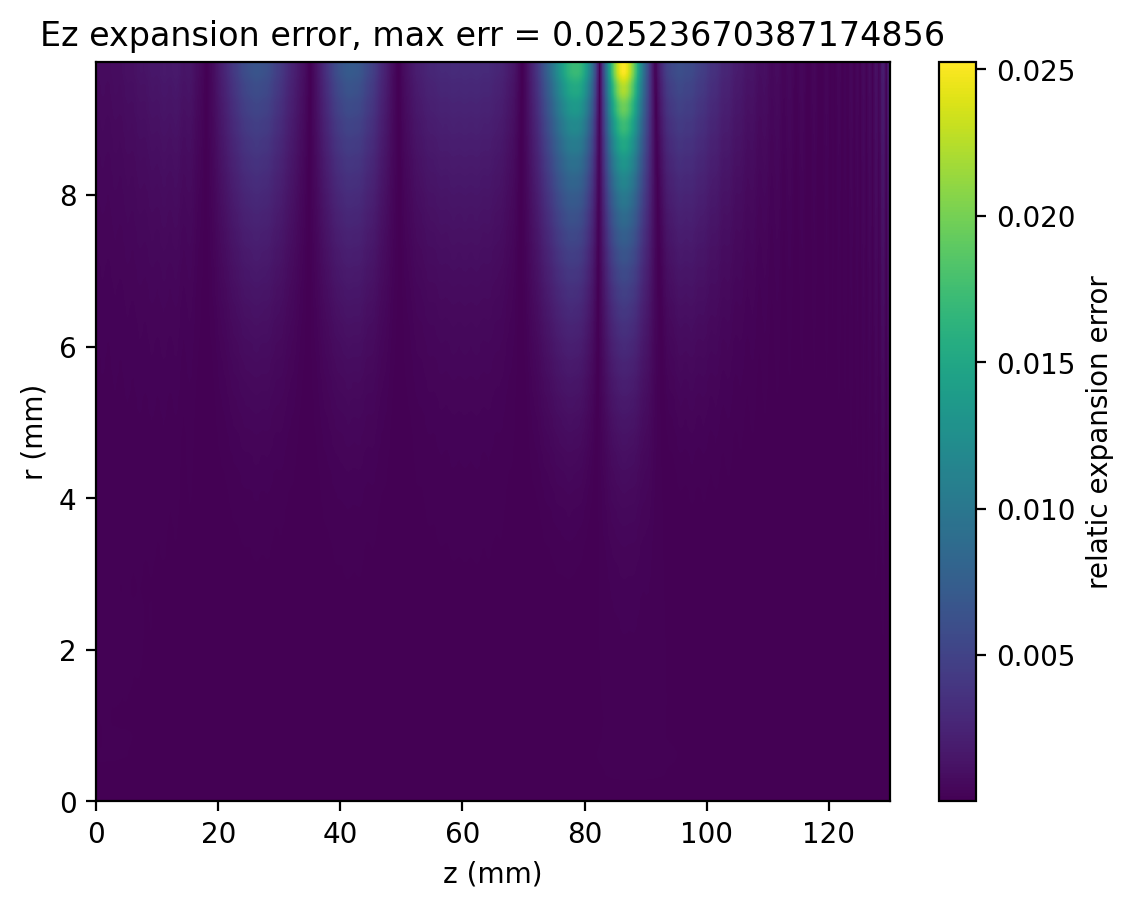

In [17]:
compare(FM, FM3, 'Ez')  

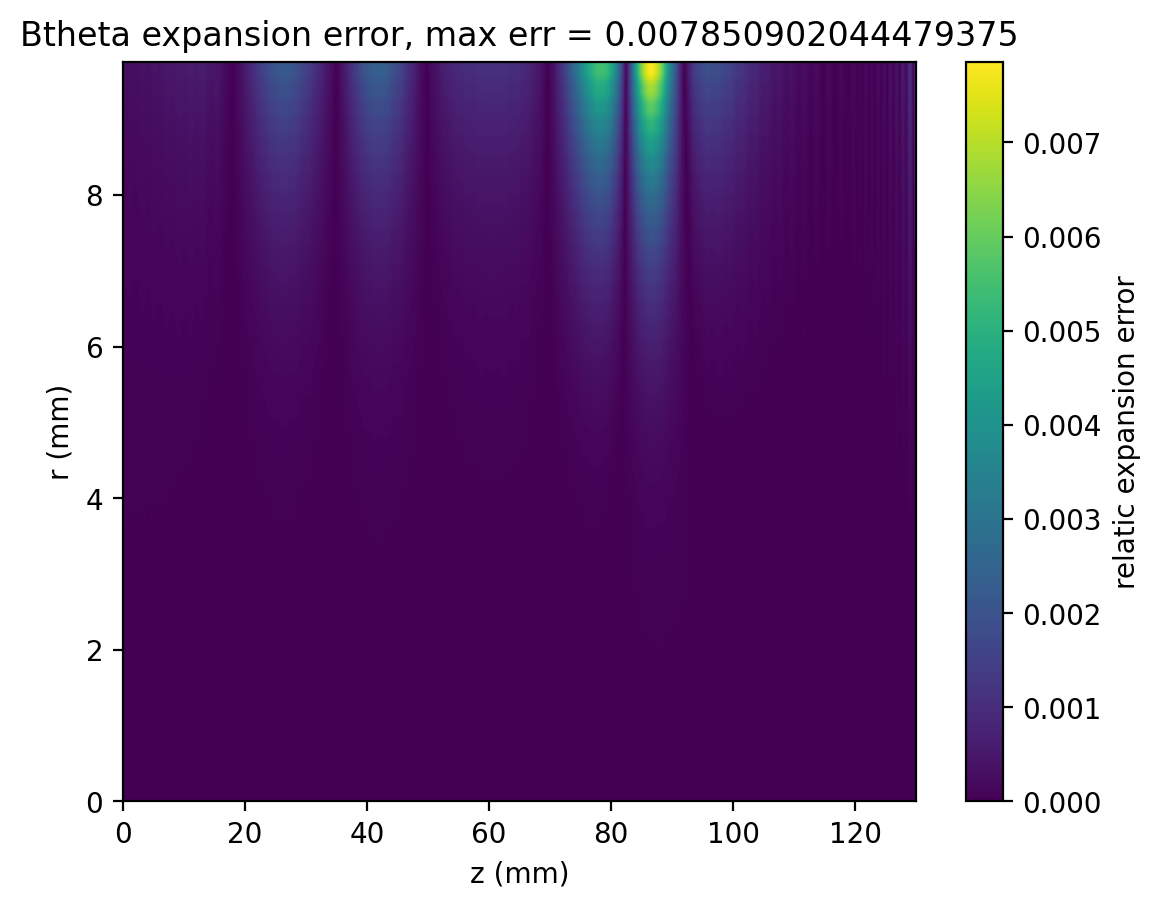

In [18]:
compare(FM, FM3, 'Btheta')  

# Spline-based expansion

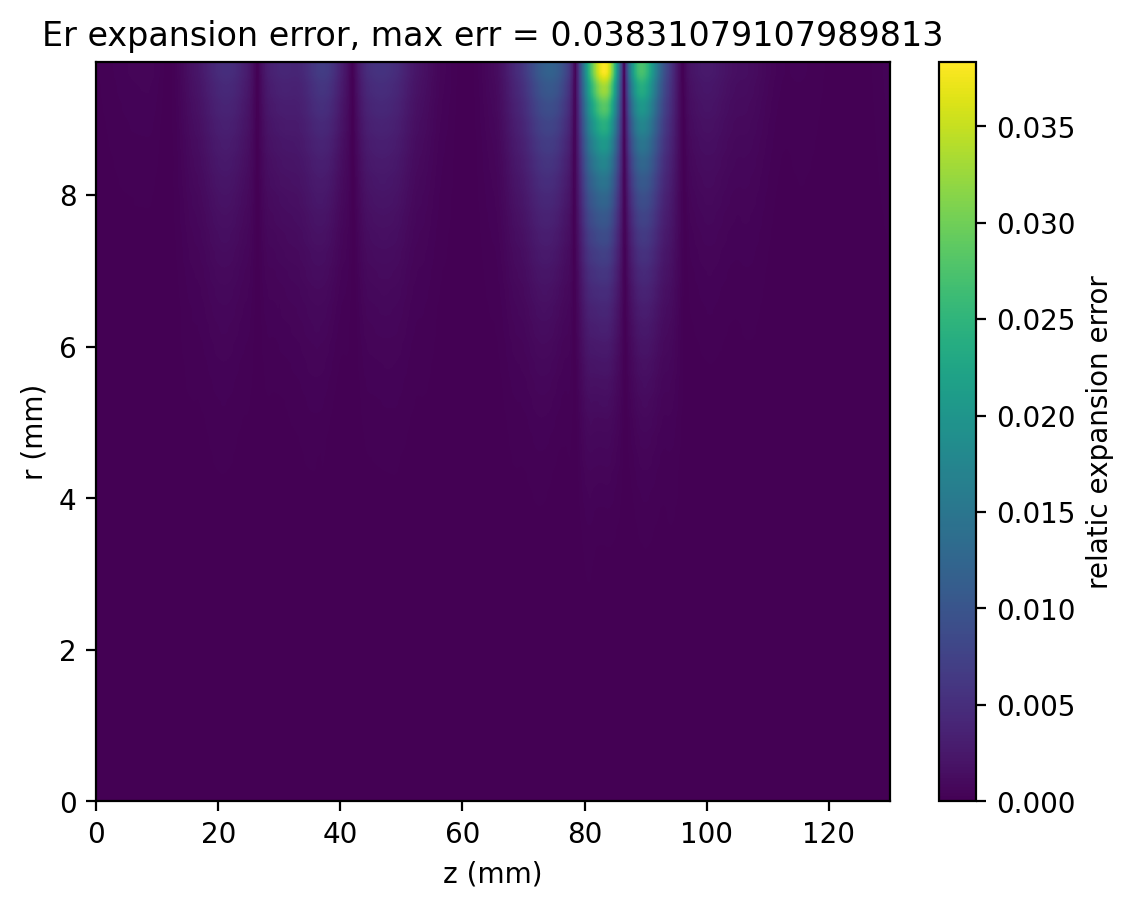

In [19]:
NR = 40
FM4 = FM2.expand_onaxis(dr=FM.dr, nr=NR, method='spline', spline_s=1e-9)
compare(FM, FM4, 'Er')   

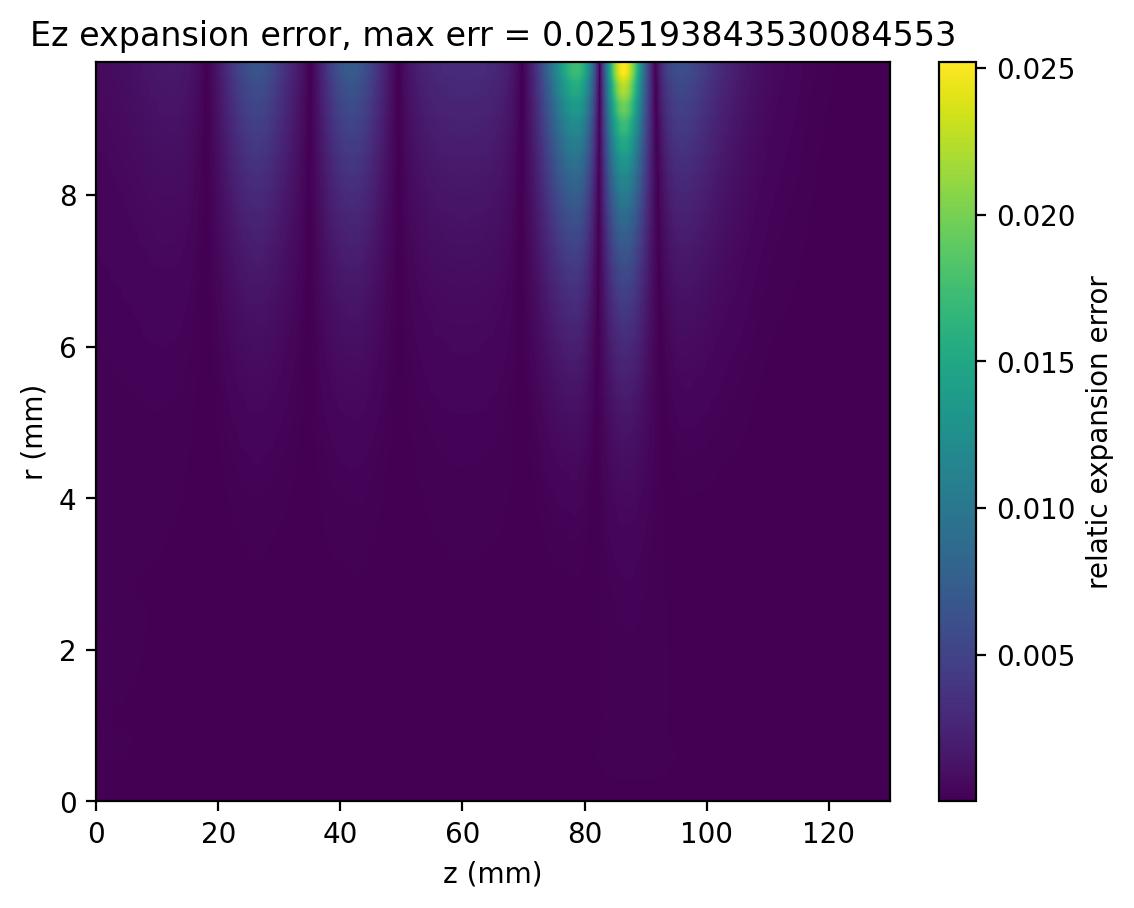

In [20]:
compare(FM, FM4, 'Ez')  

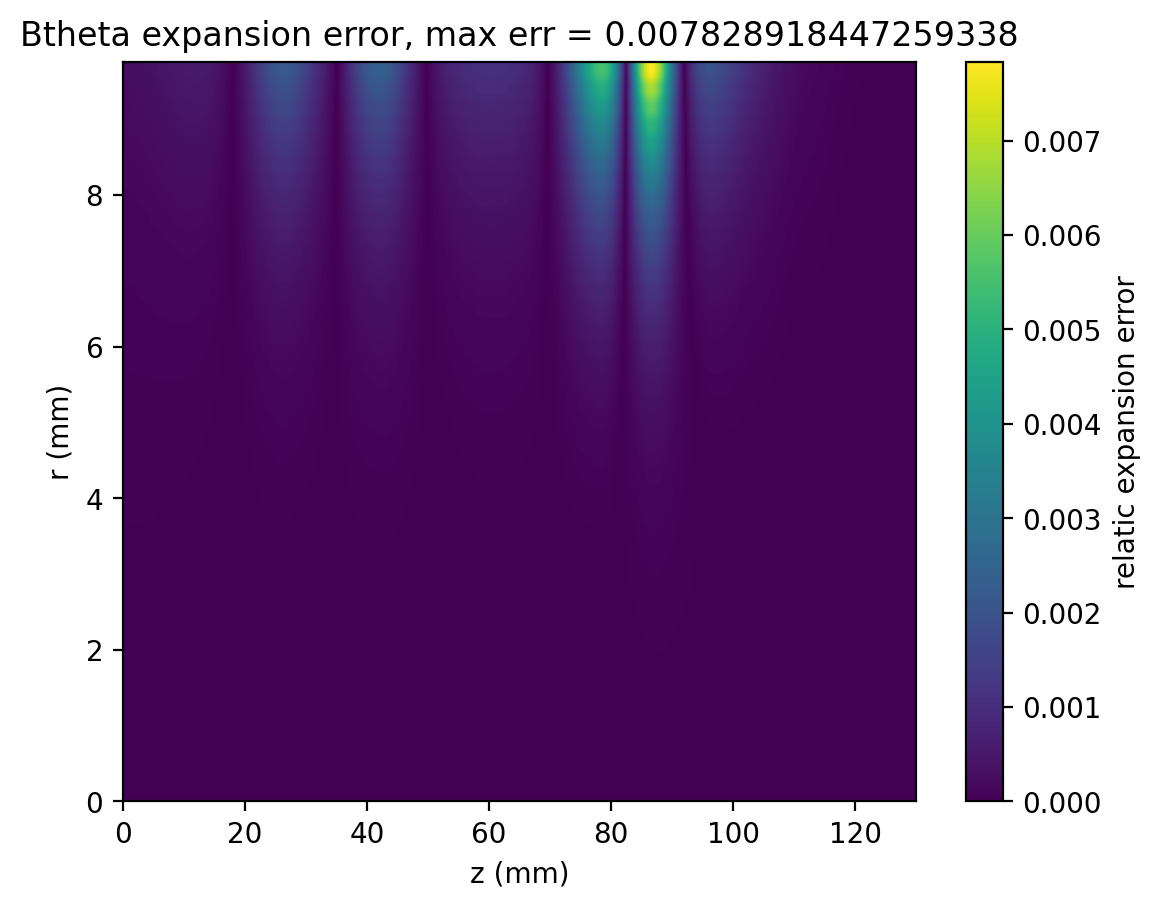

In [21]:
compare(FM, FM4, 'Btheta')  

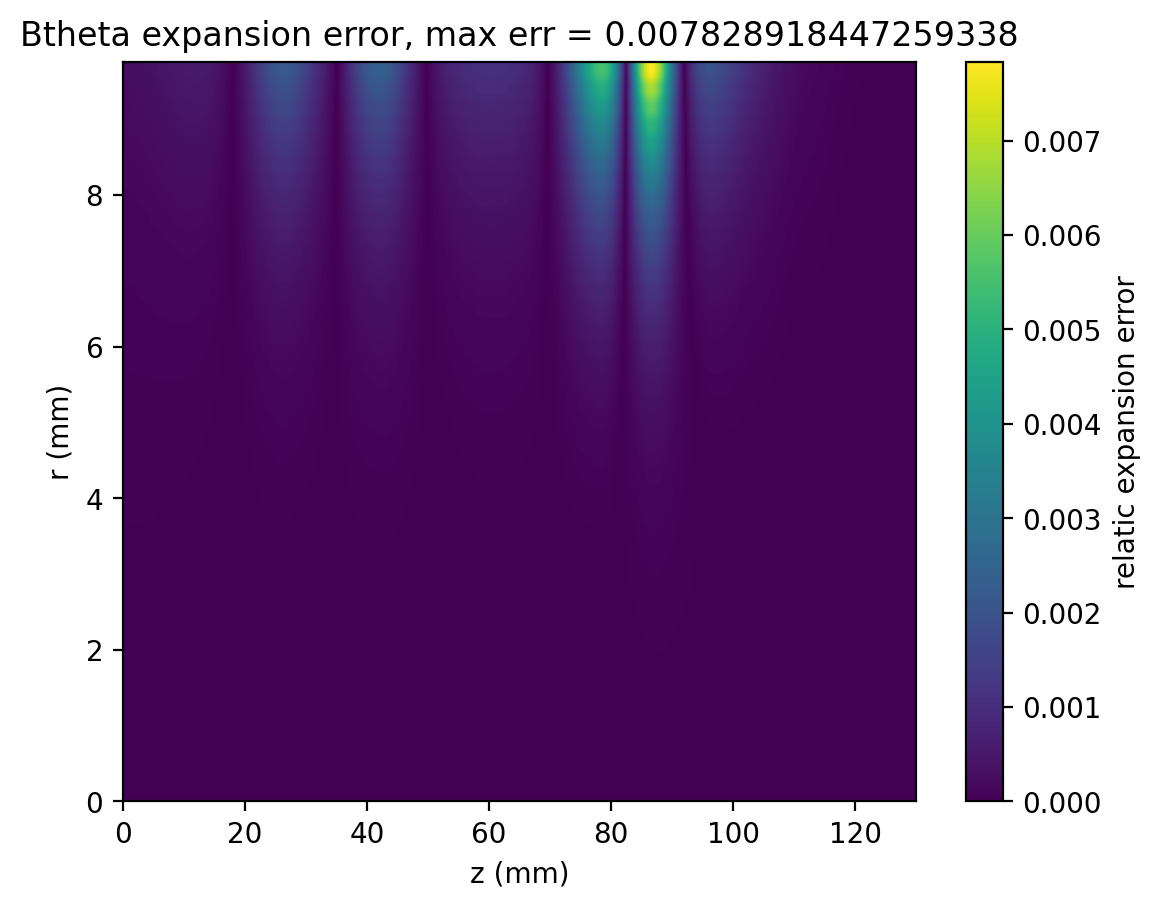

In [22]:
compare(FM, FM4, 'Btheta')  

# Compare Fourier and Spline 

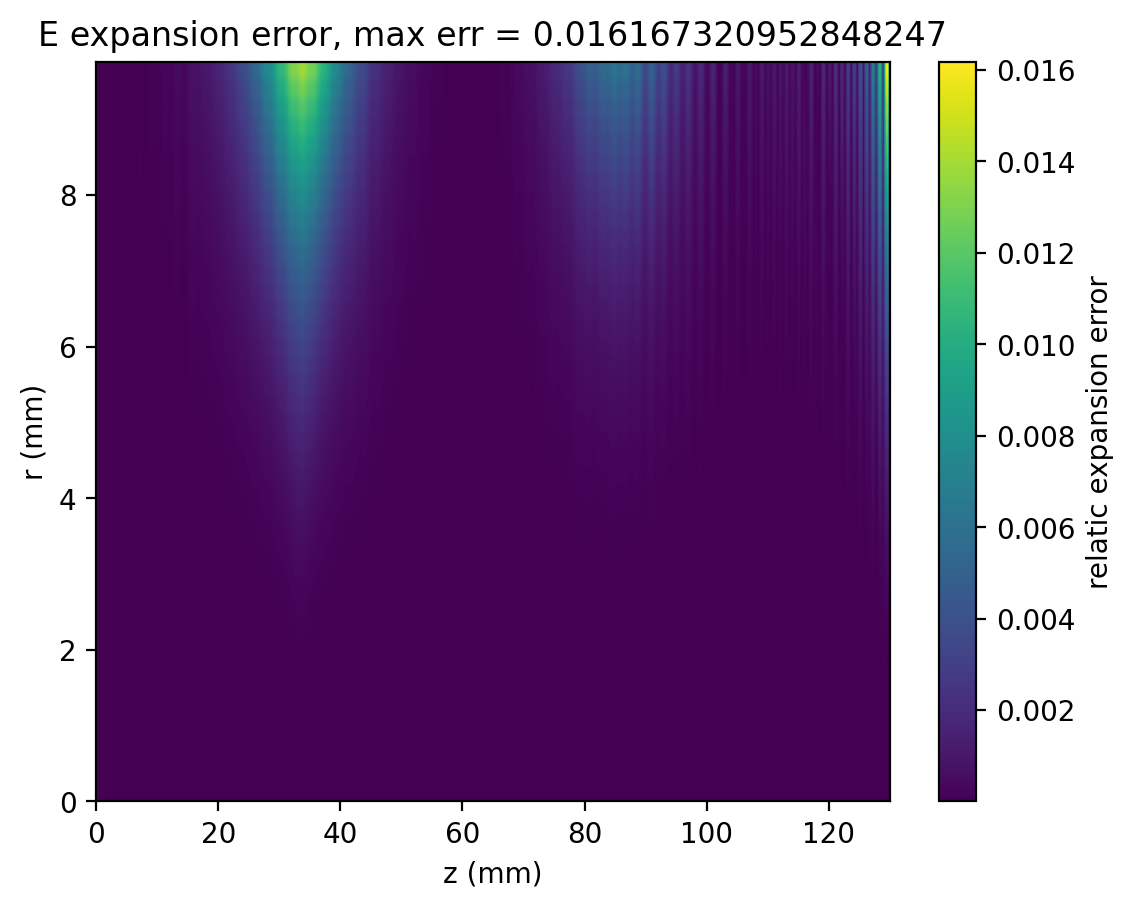

In [23]:
# Differences between the two methods
compare(FM3, FM4, 'E')  

In [24]:

def compare2(comp='Er'):
    NR = 10
    dr = FM.dr
    r = (NR-1)*FM.dr
    FM5 = FM2.expand_onaxis(dr=FM.dr, nr=NR, method='fft', ncoef=15)
    
    if comp.startswith('E'):
        func = np.real
    else:
        func = np.imag
    
    f0 = func(FM[comp][NR-1,0,:])
    
    f5 = func(FM5[comp][NR-1,0,:])
    
    FM6 = FM2.expand_onaxis(dr=FM.dr, nr=NR, method='spline', spline_s=1e-9)
    f6 = func(FM6[comp][NR-1,0,:])
    
    fix, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(f0, label='original')
    ax.plot(f5, '--', label='fourier')
    ax.plot(f6, '--', label='spline')
    ax.legend(loc='upper left')
    ax2.plot(abs((f5-f0)/f0), color='purple', label='relative fourier error')
    ax2.plot(abs((f6-f0)/f0), color='grey', label='relative spline error')
    ax2.set_yscale('log')
    ax.set_ylabel(comp)
    ax2.set_ylabel('relative error')
    ax2.legend(loc='upper right')
    ax.set_xlabel('index along z')

/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/ipykernel_95209/1820762901.py:25: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(abs((f5-f0)/f0), color='purple', label='relative fourier error')
/var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/ipykernel_95209/1820762901.py:26: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(abs((f6-f0)/f0), color='grey', label='relative spline error')


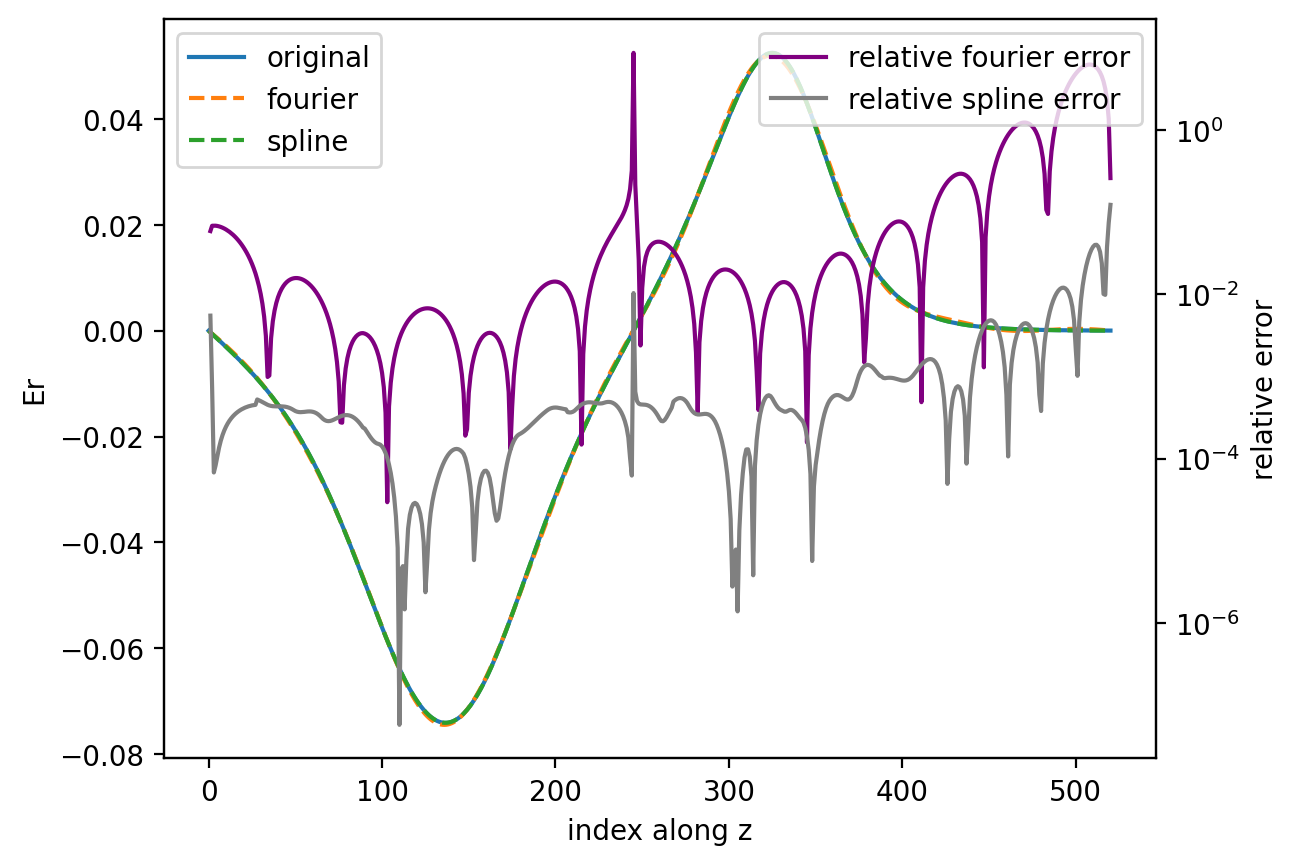

In [25]:
compare2('Er')

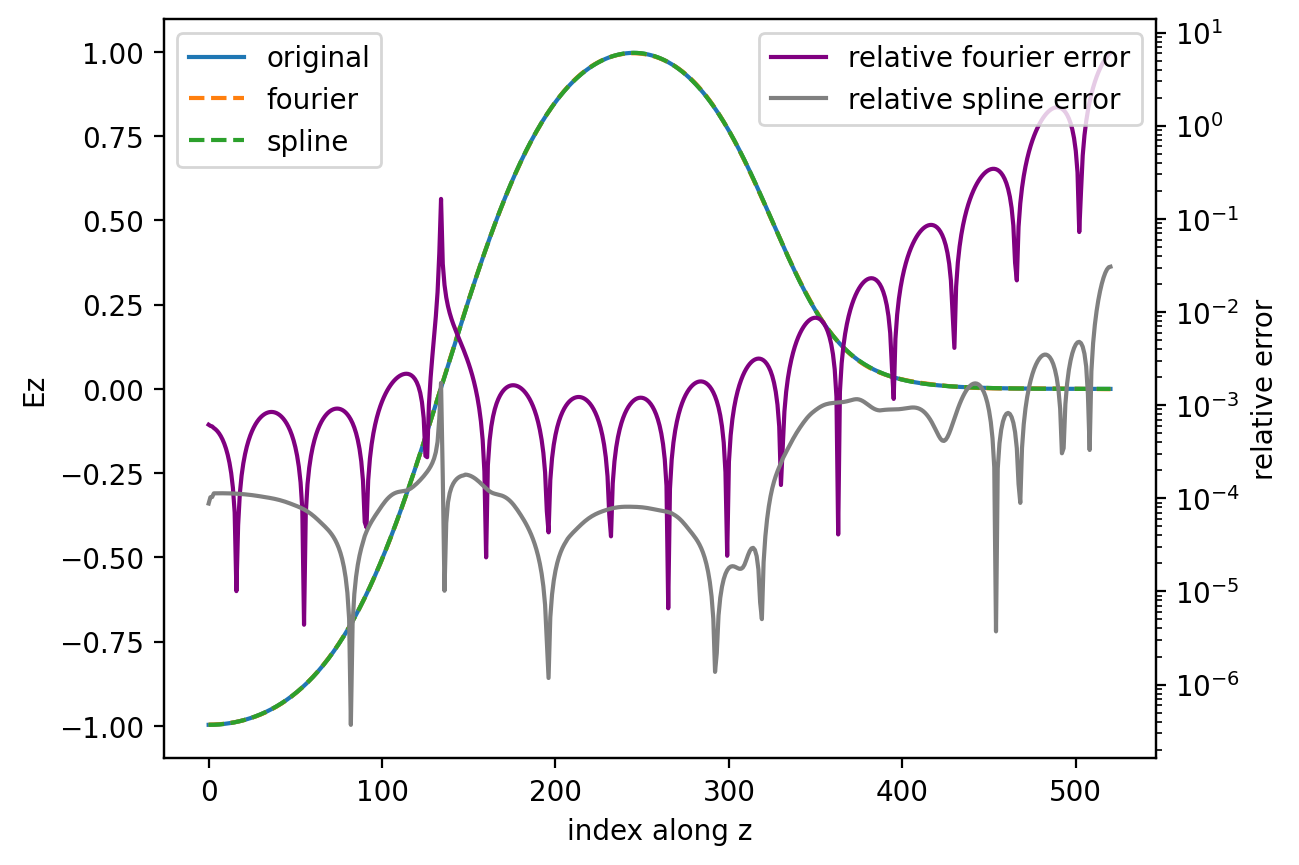

In [26]:
compare2('Ez')

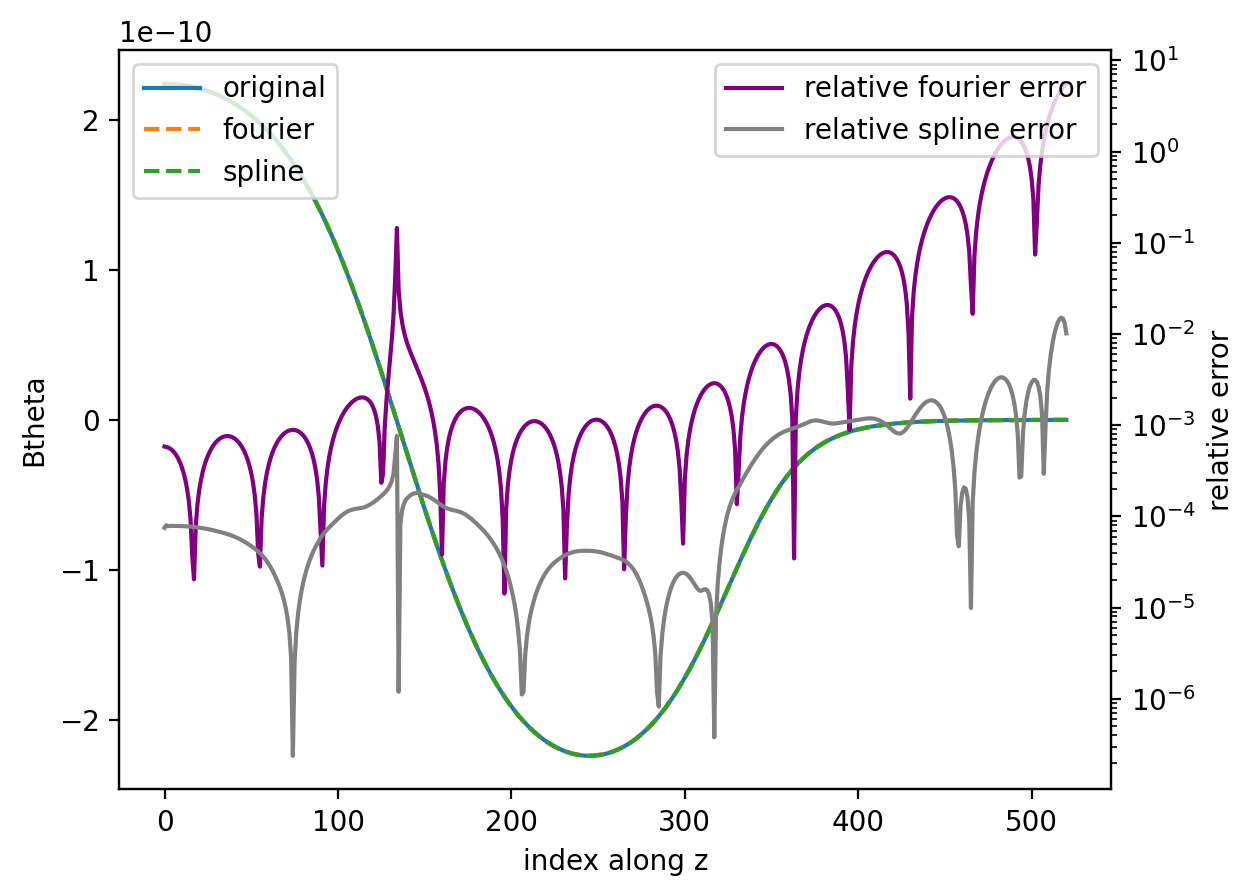

In [27]:
compare2('Btheta')